In [1]:
import yaml
from rich import print

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nitime import algorithms, utils

NEURONS_FILE = "ortone_neurons.yaml"
NETWORK_FILE = "ortone_network.yaml"
DOPAMINE_FILE = "lindahl_dopamine_susceptibility.yaml"

%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
%matplotlib inline

In [2]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

reasonable_firing = dict(FSN=15, D1=1.5, D2=1.5, GPeTI=50, GPeTA=10, STN=16)

In [3]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy import stats

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    norm = simpson(PSD, x=f)
    # print(f"f peak of {population} is {f[np.argmax(PSD)]} Hz")
    beta_mask = (f>12)&(f<30)
    beta_pow = simpson(PSD[beta_mask], x=f[beta_mask])
    # freq of max, normlized beta power, beta power, entropy
    return f[np.argmax(PSD)], beta_pow/norm, beta_pow, stats.entropy(PSD/norm)

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def get_PSD(sn, pop, frequency_resolution=0.5, smooth=False):
    spikes = sn.populations[pop].get_data('spikes')
    binned_spikes = bin_spikes(spikes)
    binned_spikes = binned_spikes[burn_in_millis:]
    T = len(binned_spikes)
    # print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")

    N = sampling_frequency/frequency_resolution
    
    if N > T/2:
        print(N)
        print(f"Not enough points to achieve resolution of {frequency_resolution}")
        N = T/2

    nfft = 10_000 if smooth else None
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=N, 
                   noverlap=N/2,
                   nfft=nfft,
                   scaling='density', 
                   window='hamming')
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    norm = simpson(PSD, x=f)
    return f, PSD
    
def plot_signals(sn, pops=None):
    if pops is None:
        pops = list(sn.populations.keys())
    colors = sns.color_palette("rainbow", 10)

    fig, ax = plt.subplot_mosaic([[pop] for pop in pops],sharex=True, figsize=(8,2*len(pops)))

    for pop in pops:    
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
            
        ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
        ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
        
        ax[pop].set_ylabel(f"{pop} [Hz]")
        ax[pop].legend()
    
    leg = ax[pops[0]].get_legend()
    for a in ax.values():
        a.legend().remove()
    
    fig.legend(handles=leg.legend_handles, loc='upper right')

In [4]:
from quilt.interface.spiking import set_verbosity
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        NEURONS_FILE,
                                        [DOPAMINE_FILE,])
sn.monitorize_spikes()

In [5]:
sn.set_parameters(dopamine=0.4)
sn.run(time=1200, dt=0.1)

Running network consisting of 14622 neurons for 12000 timesteps
--------------------------------------------------
**************************************************
Simulation took 40 s	(3.375 ms/step)
	Gathering time avg: 0.840583 us/step
	Inject time avg: 314.696 us/step
Population evolution stats:
	0:
		evolution:	936.14 us/step	---	156 ns/step/neuron
		spike emission:	61.983 us/step	---	10 ns/step/neuron
	1:
		evolution:	894.343 us/step	---	149 ns/step/neuron
		spike emission:	123.762 us/step	---	20 ns/step/neuron
	2:
		evolution:	189.05 us/step	---	450 ns/step/neuron
		spike emission:	21.5135 us/step	---	51 ns/step/neuron
	3:
		evolution:	240.231 us/step	---	307 ns/step/neuron
		spike emission:	26.4101 us/step	---	33 ns/step/neuron
	4:
		evolution:	126.317 us/step	---	485 ns/step/neuron
		spike emission:	12.8681 us/step	---	49 ns/step/neuron
	5:
		evolution:	159.293 us/step	---	390 ns/step/neuron
		spike emission:	10.1388 us/step	---	24 ns/step/neuron
	6:
		evolution:	242.22 us/s

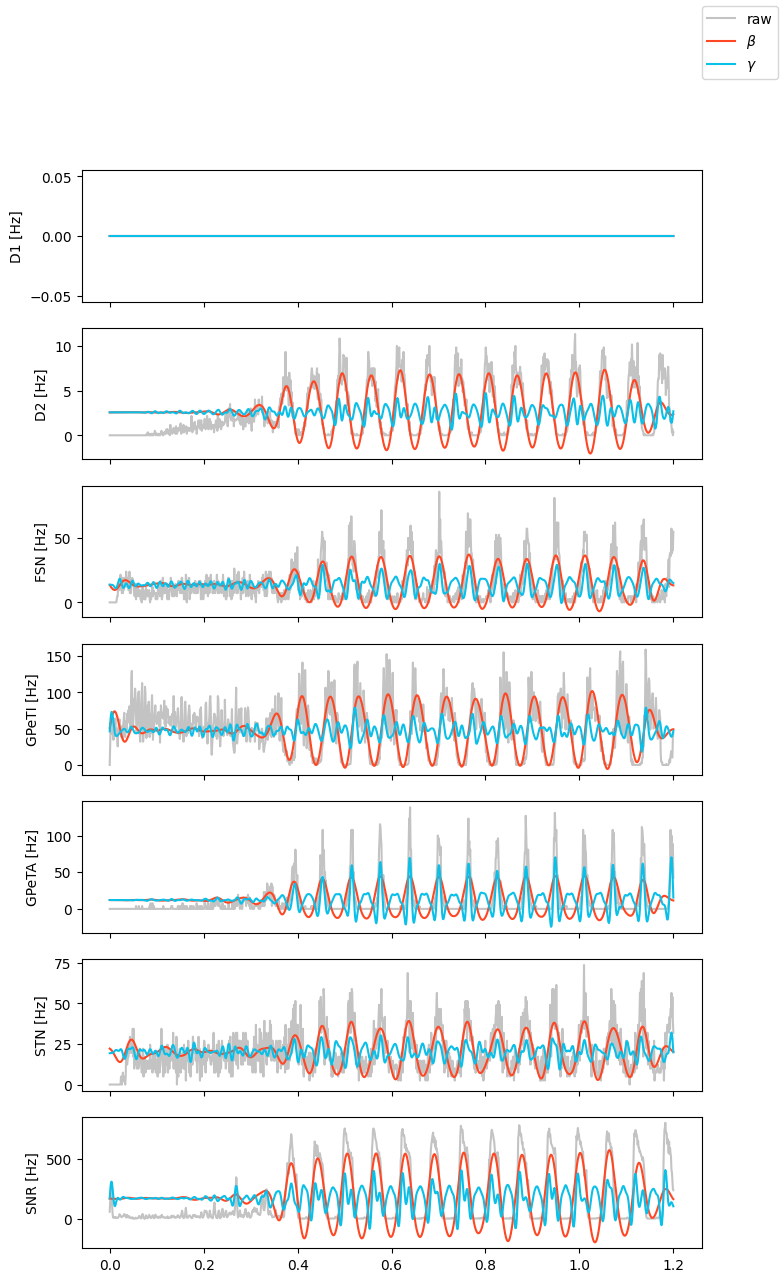

In [6]:
plot_signals(sn)

In [7]:
pop_in = ["D2", "GPeTI", "STN", "FSN"]
pop_out = pop_in.copy()
lags = np.arange(5)
signals = {pop:bin_spikes(sn.populations[pop].get_data('spikes'))[600:] for pop in list(set(pop_in).union(set(pop_out)))}

In [8]:
from rich.progress import track
M = np.zeros((len(pop_in), len(pop_out), len(lags)))

for k in track(range(len(lags))):
    for i in range(len(pop_in)):
        for j in range(len(pop_out)):
            M[i,j,k] = algorithms.transfer_entropy(signals[pop_in[i]], signals[pop_out[j]], lag=lags[k])

Output()

Text(0.5, 0, 'Lag [ms]')

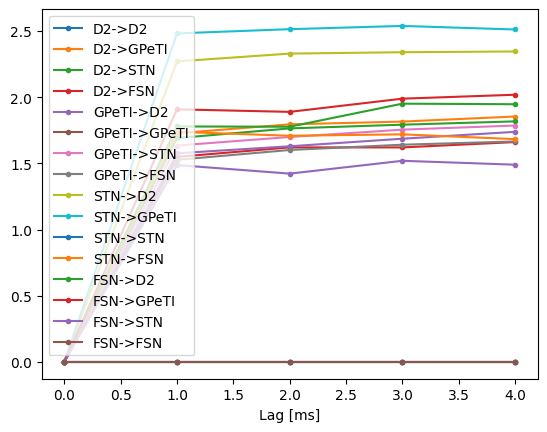

In [9]:
for i in range(len(pop_in)):
    for j in range(len(pop_out)):
        plt.plot(lags,M[i,j,:], label = f"{pop_in[i]}->{pop_out[j]}", marker=".")
plt.legend()
plt.xlabel("Lag [ms]")

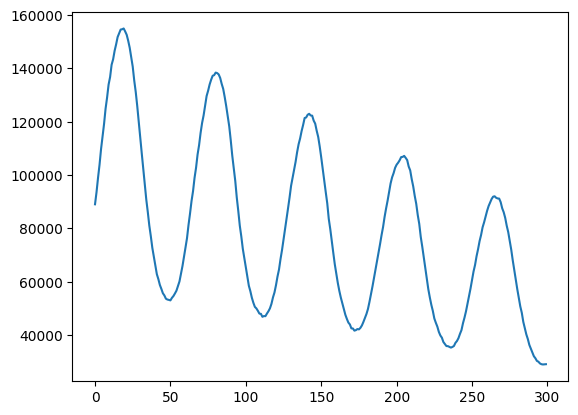

In [10]:
from scipy.signal import correlate
corr = correlate(signals['STN'], signals['D2'], mode='same')
plt.plot(corr[len(corr)//2:])